In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evolution.evaluation.evaluator import Evaluator
from experiments.experiment_utils import Experimenter
from generate_url import open_browser, actions_to_url

In [2]:
results_dir = Path("results/energy/newobjectives")
config = json.load(open(results_dir / "config.json"))
gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

100 {'Temperature above 1.5C': True, 'Max cost of energy': True, 'Government net revenue below zero': False, 'Total energy below baseline': False} 61 178


In [3]:
model_params = config["model_params"]
input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
model_params["in_size"] = len(context) if len(context) > 0 else len(input_specs) - len(actions)
model_params["out_size"] = len(actions)

evaluator = Evaluator("experiments/temp", context, actions, outcomes)
experimenter = Experimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [4]:
def get_search_space_size(actions: list[str]):
    input_specs = pd.read_json("inputSpecs.jsonl", lines=True, precise_float=True)
    size = 1
    for action in actions:
        row = input_specs[input_specs["varId"] == action].iloc[0]
        if row["kind"] == "switch":
            size *= 2
        elif row["kind"] == "slider":
            combs = int((row["maxValue"] - row["minValue"]) / row["step"])
            size *= combs
    
    size = int(size)
    return size

size = get_search_space_size(actions)
n_atoms = 1e82
print(f"{size:.2e}")
f"{size / n_atoms:.2e}"

1.72e+96


'1.72e+14'

In [5]:
baseline_actions = {}
baseline_df = evaluator.enroads_runner.evaluate_actions(baseline_actions)
outcome_keys = list(outcomes.keys())
dummy_output = pd.read_csv(Path("experiments/temp/enroads_output.txt"), sep="\t")
enroads_outcomes = [outcome for outcome in outcomes if outcome in dummy_output.columns]
enroads_outcomes = list(set(enroads_outcomes + ["Temperature change from 1850",
                                                "CO2 Equivalent Net Emissions",
                                                "Adjusted cost of energy per GJ",
                                                "Government net revenue from adjustments",
                                                "Total Primary Energy Demand"]))
baseline_metrics = evaluator.outcome_manager.process_outcomes(baseline_actions, baseline_df)
for outcome in outcomes:
    print(f"{outcome}: {baseline_metrics[outcome]}")

print(enroads_outcomes)

Temperature above 1.5C: 1.8296800000000002
Max cost of energy: 22.8157
Government net revenue below zero: 0
Total energy below baseline: 0.0
['Government net revenue from adjustments', 'Adjusted cost of energy per GJ', 'CO2 Equivalent Net Emissions', 'Temperature change from 1850', 'Total Primary Energy Demand']


In [6]:
final_gen_df = pd.read_csv(results_dir / f"{gens}.csv")
final_pareto = final_gen_df[final_gen_df["rank"] == 1]
final_pareto

,cand_id,parents,rank,distance,Temperature above 1.5C,Max cost of energy,Government net revenue below zero,Total energy below baseline
0,74_81,"['70_66', '70_66']",1,inf,0.84245,22.8157,-96.588618,-13227.756
1,89_78,"['82_9', '82_9']",1,inf,0.80401,23.3360,-171.685939,-12322.358
2,93_73,"['90_62', '90_62']",1,inf,1.82968,22.8157,0.000000,0.000
3,97_67,"['96_29', '96_29']",1,inf,0.61391,30.9398,0.000000,-18444.783
4,100_61,"['84_72', '98_33']",1,inf,0.59260,31.0442,-5.379143,-18896.802
...,...,...,...,...,...,...,...,...
81,100_53,"['99_28', '99_63']",1,0.034750,1.01084,24.7343,-24.308516,-18233.612
82,100_49,"['99_14', '99_66']",1,0.033967,1.09355,23.6325,-23.976701,-13804.177
83,100_56,"['74_81', '99_76']",1,0.027581,0.79344,23.8734,-42.757583,-13879.915
84,98_33,"['97_67', '96_29']",1,0.024490,0.61112,31.0311,-0.839367,-18525.246


In [7]:
def evenly_sample(lst, m):
    middle = lst[1:-1]
    step = len(middle) / (m-2)
    sample = [middle[int(i * step)] for i in range(m-2)]
    sample = [lst[0]] + sample + [lst[-1]]
    return sample

In [8]:
if len(final_pareto) < 10:
    sample_points = final_pareto["cand_id"].tolist()
else:
    outcome_sort = outcome_keys[1]
    sample_points = final_pareto.sort_values(outcome_sort, ascending=outcomes[outcome_sort])["cand_id"].tolist()
    sample_points = evenly_sample(sample_points, 9)

    # sample_pareto = final_pareto[final_pareto["Temperature change from 1850"] <= 1.5].sort_values("Cost change year", ascending=False)
    # sample_points = evenly_sample(sample_pareto["cand_id"].tolist(), 9)
    # sample_pareto

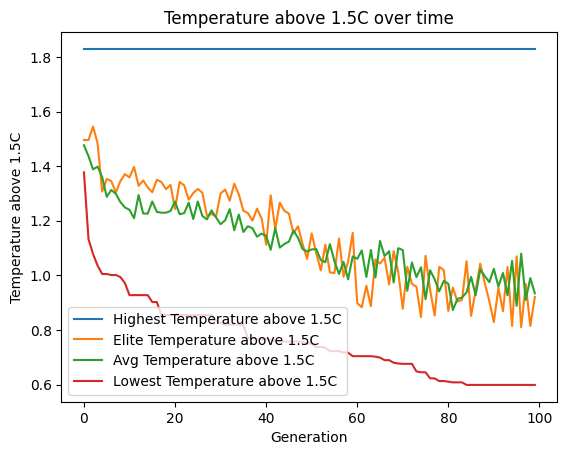

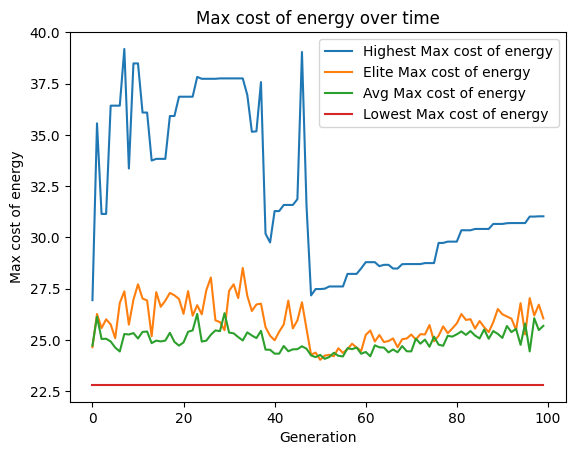

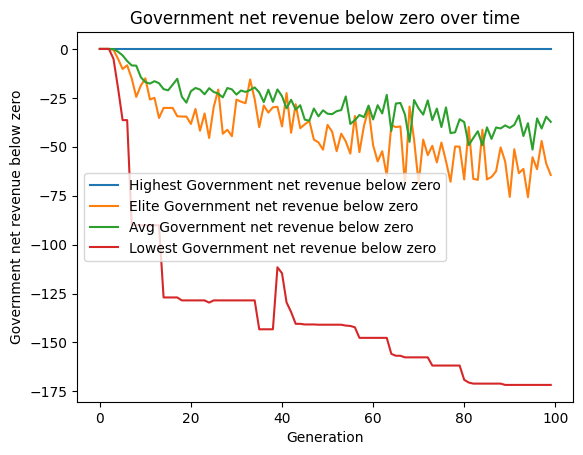

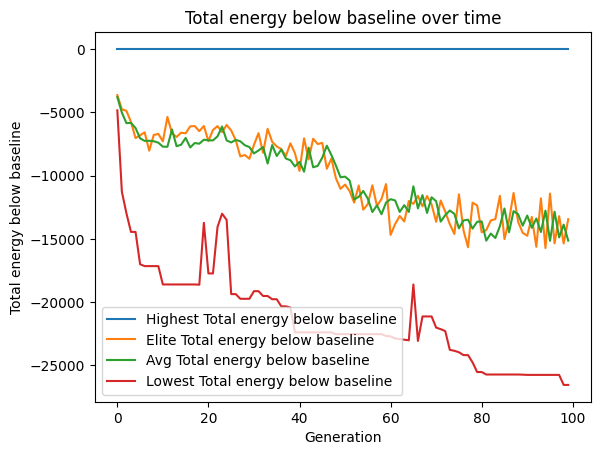

In [9]:
def plot_objective_over_time(outcome):
    best = []
    worst = []
    avg = []
    elite = []
    for gen in range(gens):
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        pareto = gen_df[gen_df["rank"] == 1]
        scores = pareto.sort_values("distance", ascending=False)[outcome]
        best.append(scores.max())
        worst.append(scores.min())
        avg.append(scores.mean())
        elite.append(scores.iloc[:n_elites].mean())
    
    # plt.plot(range(gens), [baseline_df[outcome].iloc[-1] for _ in range(gens)], label=f"Baseline {outcome}", color="black")

    plt.plot(range(gens), best, label=f"Highest {outcome}")
    plt.plot(range(gens), elite, label=f"Elite {outcome}")
    plt.plot(range(gens), avg, label=f"Avg {outcome}")
    plt.plot(range(gens), worst, label=f"Lowest {outcome}")
    plt.legend()
    plt.xlabel("Generation")
    plt.ylabel(outcome)
    plt.title(f"{outcome} over time")
    plt.show()

for outcome in outcomes:
    plot_objective_over_time(outcome)

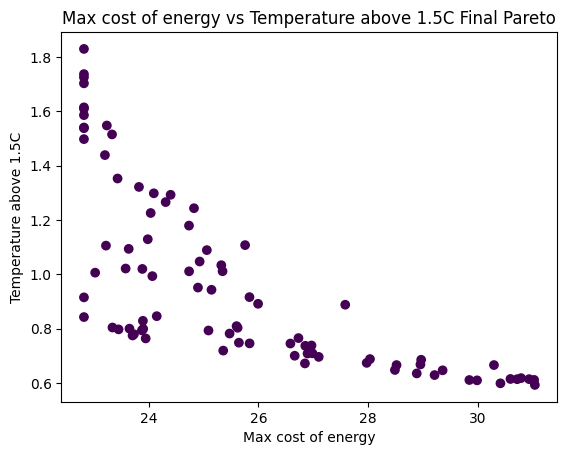

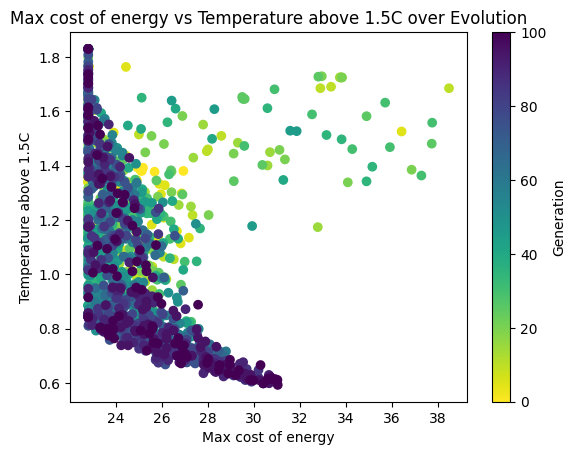

In [10]:
def plot_two_objective(outcome1, outcome2, gens, pareto=True):

    gen_dfs = []
    for gen in gens:
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        gen_df = gen_df[gen_df["rank"] == 1] if pareto else gen_df
        gen_df["color"] = gen
        gen_dfs.append(gen_df)
    
    total_gen_df = pd.concat(gen_dfs)
    cmap = "viridis_r" if len(gens) != 1 else "viridis"
    plt.scatter(total_gen_df[outcome1], total_gen_df[outcome2], c=total_gen_df["color"], cmap=cmap)

    title = f"{outcome1} vs {outcome2} Final Pareto"
    if len(gens) != 1:
        plt.colorbar(label="Generation")
        title = f"{outcome1} vs {outcome2} over Evolution"
    plt.title(title)
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_two_objective(outcome_keys[1], outcome_keys[0], [gens])
plot_two_objective(outcome_keys[1], outcome_keys[0], range(0, gens+1, 5))

In [11]:
best_cand_ids = []
for outcome, ascending in outcomes.items():
    best_cand_ids.append(final_pareto.sort_values(outcome, ascending=ascending).iloc[0]["cand_id"])
    print(final_pareto.sort_values(outcome, ascending=ascending).iloc[0][outcome_keys])
    print()
best_cand_ids = list(set(best_cand_ids))
best_cand_ids

Temperature above 1.5C                  0.5926
Max cost of energy                     31.0442
Government net revenue below zero    -5.379143
Total energy below baseline         -18896.802
Name: 4, dtype: object

Temperature above 1.5C                 0.84245
Max cost of energy                     22.8157
Government net revenue below zero   -96.588618
Total energy below baseline         -13227.756
Name: 0, dtype: object

Temperature above 1.5C                 1.01116
Max cost of energy                     25.3452
Government net revenue below zero          0.0
Total energy below baseline         -18270.668
Name: 85, dtype: object

Temperature above 1.5C               1.82968
Max cost of energy                   22.8157
Government net revenue below zero        0.0
Total energy below baseline              0.0
Name: 2, dtype: object



['74_81', '100_61', '100_14', '93_73']

In [12]:
context_input, context_vals = evaluator.context_dataset[0]

   cand_id             parents  rank  distance  Temperature above 1.5C  \
0    74_81  ['70_66', '70_66']     1       inf                 0.84245   
4   100_61  ['84_72', '98_33']     1       inf                 0.59260   
8   100_66  ['93_73', '74_81']     1  0.226004                 1.43882   
10   100_5  ['89_78', '93_73']     1  0.168052                 1.32155   
11  100_36  ['74_81', '99_12']     1  0.164951                 1.29262   
41  100_29  ['99_54', '99_63']     1  0.092220                 1.53783   
57  100_71  ['98_33', '99_28']     1  0.070483                 0.68522   
61  100_12  ['89_78', '98_64']     1  0.064624                 0.78173   
73  100_20  ['89_78', '97_67']     1  0.047462                 0.73673   

    Max cost of energy  Government net revenue below zero  \
0              22.8157                         -96.588618   
4              31.0442                          -5.379143   
8              23.1986                          -5.006636   
10             

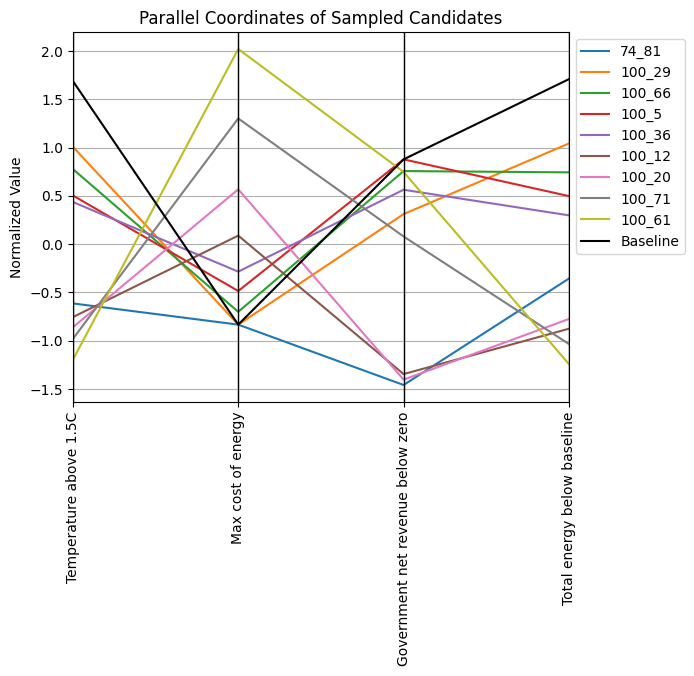

In [13]:
def plot_parallel_coordinates(cand_ids):
    coords_dicts = []
    for cand_id in cand_ids:
        gen = int(cand_id.split("_")[0])
        gen_df = pd.read_csv(results_dir / f"{gen}.csv")
        row = gen_df[gen_df["cand_id"] == cand_id].iloc[0]
        cand_coords = [row[outcome] for outcome in outcomes]
        cand_dict = dict(zip(outcomes.keys(), cand_coords))
        cand_dict["cand_id"] = cand_id
        coords_dicts.append(cand_dict)

    baseline_dict = {outcome: metric for outcome, metric in baseline_metrics.items()}
    baseline_dict["cand_id"] = "Baseline"
    coords_dicts.append(baseline_dict)

    coords_df = pd.DataFrame(coords_dicts)
    normalized_df = coords_df[outcomes.keys()]
    normalized_df = (normalized_df - normalized_df.mean()) / (normalized_df.std() + 1e-10)
    normalized_df["cand_id"] = coords_df["cand_id"]
    
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    # Color baseline black
    colors[len(coords_df)-1] = "black" 
    pd.plotting.parallel_coordinates(normalized_df, "cand_id", color=colors)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.ylabel("Normalized Value")
    plt.title("Parallel Coordinates of Sampled Candidates")

plot_parallel_coordinates(sample_points)
print(final_pareto[final_pareto["cand_id"].isin(sample_points)])

In [14]:
def get_average_df(dfs: list[pd.DataFrame]):
    avg_df = dfs[0].copy()
    for df in dfs[1:]:
        avg_df += df
    avg_df /= len(dfs)
    return avg_df

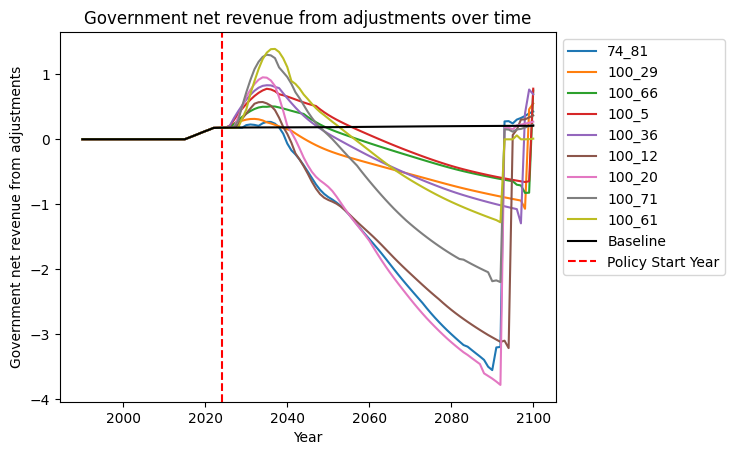

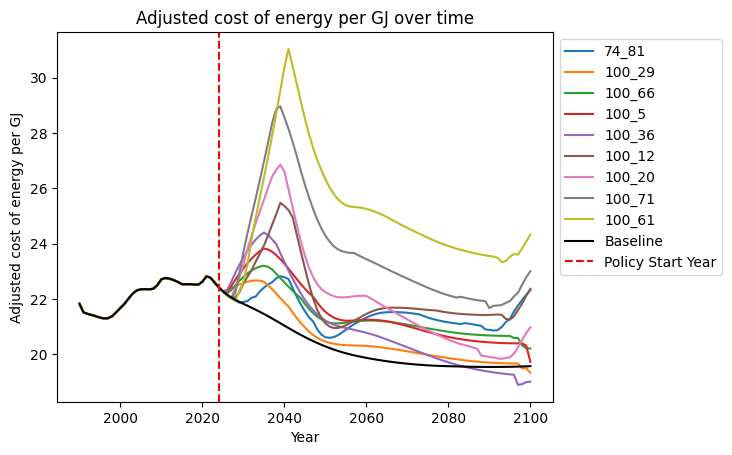

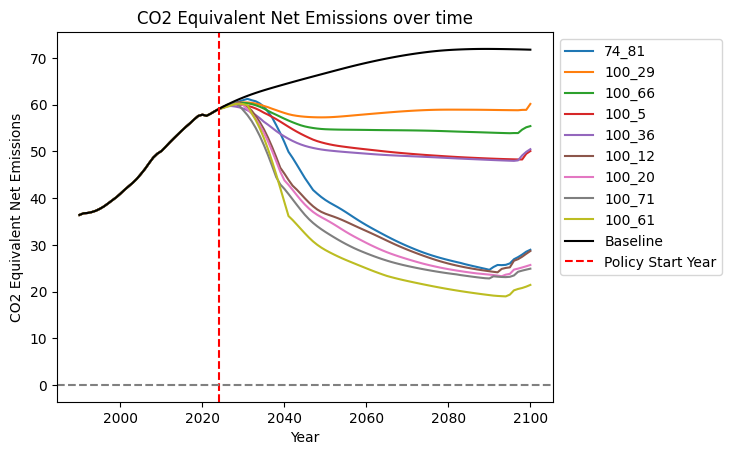

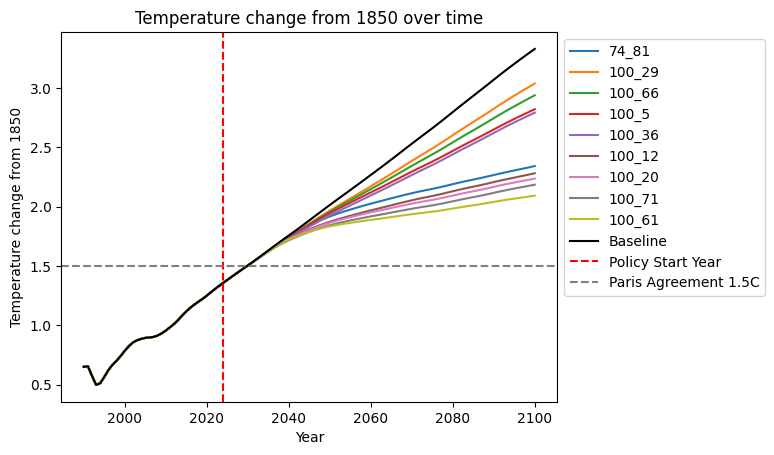

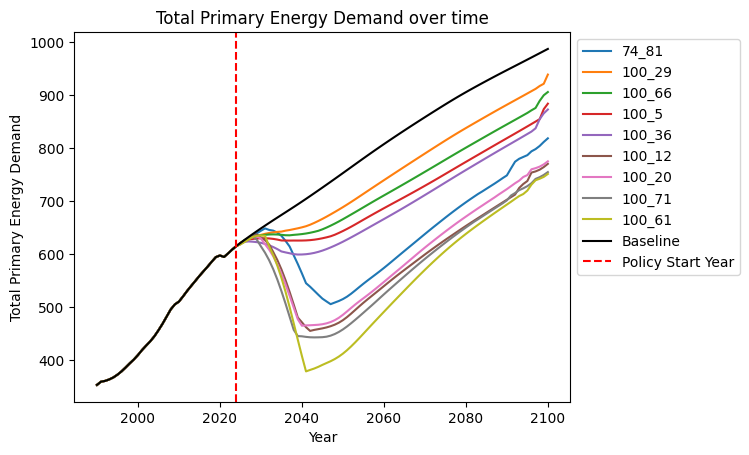

In [15]:
def plot_outcome_over_time(outcome, cand_ids, paris=False):
    for cand_id in cand_ids:
        cand = experimenter.get_candidate_from_id(cand_id)
        cand_outcomes = evaluator.evaluate_candidate(cand)
        avg_df = get_average_df(cand_outcomes)
        plt.plot(range(1990, 2101), avg_df[outcome], label=f"{cand_id}")
    plt.plot(range(1990, 2101), baseline_df[outcome], color="black", label="Baseline")
    plt.axvline(x=2024, color="red", linestyle="--", label="Policy Start Year")

    if outcome == "CO2 Equivalent Net Emissions":
        plt.axhline(y=0, color="gray", linestyle="--")
        if paris:
            plt.axhline(y=54.4789*0.55, color="orange", linestyle="--", label="Paris Agreement 45% Reduction")
            plt.axvline(x=2035, color="orange", linestyle="--")
            plt.axvline(x=2050, color="gray", linestyle="--", label="Paris Agreement Net Zero")

    elif outcome == "Temperature change from 1850":
        plt.axhline(y=1.5, color="gray", linestyle="--", label="Paris Agreement 1.5C")

    plt.legend(bbox_to_anchor=(1, 1))
    if len(cand_outcomes) > 1:
        plt.title(f"Average {outcome} over time over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"{outcome} over time")
    plt.xlabel("Year")
    plt.ylabel(outcome)
    plt.show()

paris = "Emissions Above Paris Agreement" in outcomes
for outcome in enroads_outcomes:
    plot_outcome_over_time(outcome, sample_points, paris)

In [16]:
def plot_energy_usage(cand_ids):
    fig, axes = plt.subplots(1, len(cand_ids), sharey=True, figsize=(7.5 * len(cand_ids), 5))
    if len(cand_ids) == 1:
        axes = [axes]
    axes[0].set_ylabel("Energy (Exajoules / year)")
    for cand_id, ax in zip(cand_ids, axes):
        cand_outcomes = None
        if cand_id == "baseline":
            cand_outcomes = baseline_df
        else:
            cand = experimenter.get_candidate_from_id(cand_id)
            outcomes = evaluator.evaluate_candidate(cand)
            cand_outcomes = get_average_df(outcomes)
        colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
        energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
        demands = [f"Primary energy demand of {energy}" for energy in energies]
        energy_df = cand_outcomes[demands]
        for i, demand in enumerate(demands):
            base = 0
            if i != 0:
                for j in range(i):
                    base += energy_df[demands[j]]
            if energy_df[demand].sum() == 0:
                continue
            ax.fill_between(range(1990, 2101), base, base + energy_df[demand], label=energies[i], color=colors[i], alpha=0.8)
        if cand_id != "baseline" and len(outcomes) > 1:
            ax.set_title(f"Average Energy Usage for Candidate {cand_id}")
        else:
            ax.set_title(f"Energy Usage for {cand_id}")
        ax.set_xlabel("Year")
        ax.axvline(x=2024, color="red", linestyle="--")

    plt.suptitle("Global Sources of Primary Energy")
    # Reverse the legend order
    plt.legend(reversed(ax.get_legend_handles_labels()[0]), reversed(ax.get_legend_handles_labels()[1]))
    plt.show()

In [17]:
def plot_energy_difference(cand_id):
    colors = ["brown", "red", "blue", "green", "pink", "lightblue", "orange"]
    energies = ["coal", "oil", "gas", "renew and hydro", "bio", "nuclear", "new tech"]
    demands = [f"Primary energy demand of {energy}" for energy in energies]

    cand = experimenter.get_candidate_from_id(cand_id)
    cand_outcomes = evaluator.evaluate_candidate(cand)
    avg_outcomes = get_average_df(cand_outcomes)
    energy_df = avg_outcomes[demands]

    energy_baseline = baseline_df[demands]

    diff_df = energy_df - energy_baseline
    plt.grid(axis="y")
    plt.bar(energies, diff_df.iloc[-1], color=colors)
    plt.ylabel("Difference in Energy (Exajoules / year)")
    plt.xlabel("Energy Source")
    if len(cand_outcomes) > 1:
        plt.title(f"Average Difference in Energy from Baseline for {cand_id} in 2100 over {len(cand_outcomes)} contexts")
    else:
        plt.title(f"Difference in Energy from Baseline for {cand_id} in 2100")
    plt.xticks(rotation=90)
    plt.show()

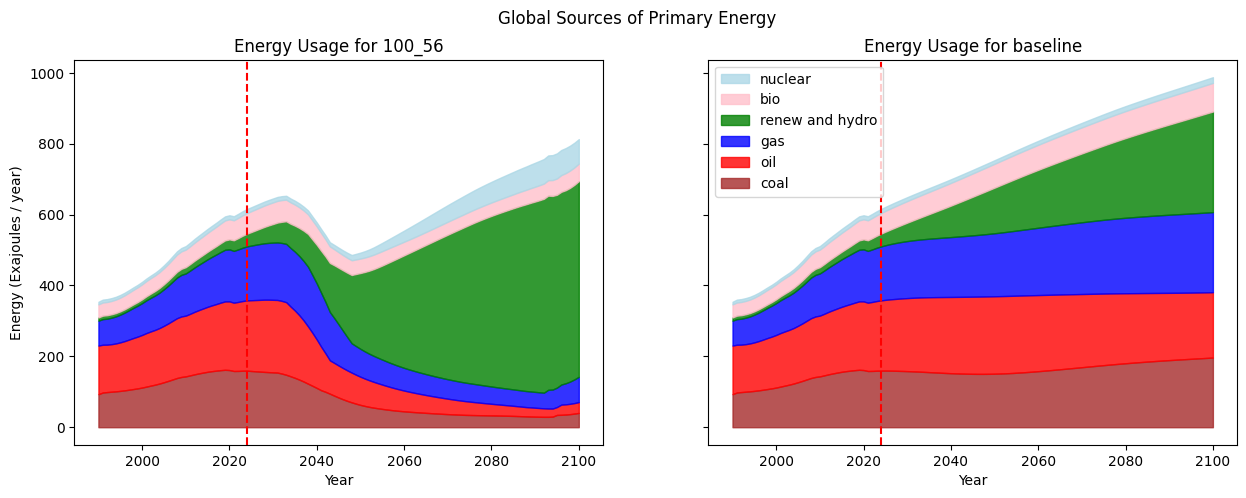

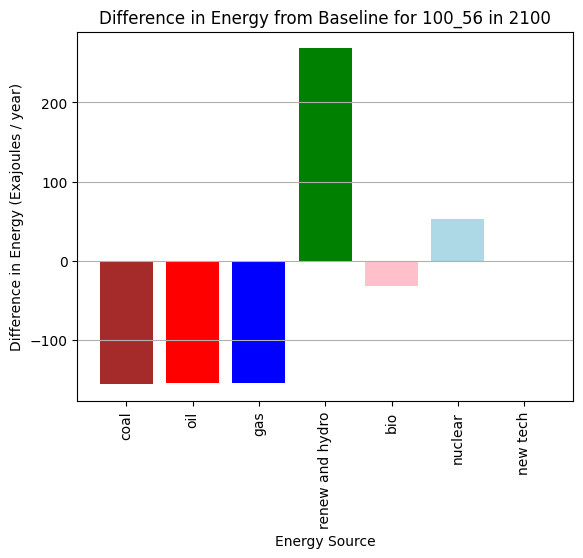

In [18]:
examples = ["100_56"]
plot_energy_usage(examples +  ["baseline"])
plot_energy_difference(examples[0])

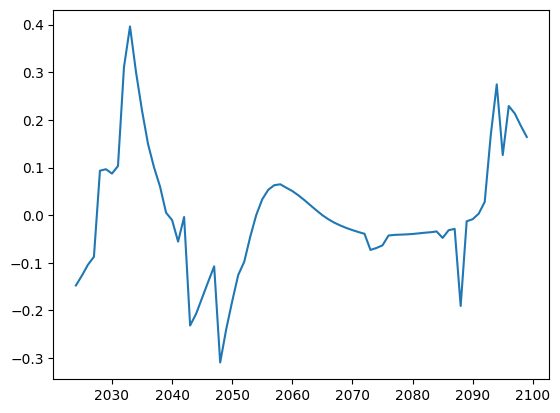

[-0.1474999999999973, -0.12690000000000268, -0.10409999999999897, -0.08729999999999905, 0.09339999999999904, 0.09649999999999892, 0.08740000000000236, 0.10319999999999752, 0.31120000000000303, 0.39620000000000033, 0.3003, 0.2195999999999998, 0.1493000000000002, 0.1001999999999974, 0.05990000000000251, 0.005199999999998539, -0.010200000000001097, -0.055399999999998784, -0.003800000000001802, -0.23160000000000025, -0.20689999999999742, -0.1734000000000009, -0.1399000000000008, -0.10739999999999839, -0.3092000000000006, -0.23959999999999937, -0.18060000000000187, -0.12549999999999883, -0.09779999999999944, -0.04520000000000124, 0.0004999999999988347, 0.03340000000000032, 0.05339999999999989, 0.06300000000000239, 0.06489999999999796, 0.05760000000000076, 0.05069999999999908, 0.04180000000000206, 0.03170000000000073, 0.020899999999997476, 0.010200000000001097, 0.0, -0.008600000000001273, -0.015799999999998704, -0.021699999999999164, -0.026900000000001256, -0.03129999999999811, -0.0354000000

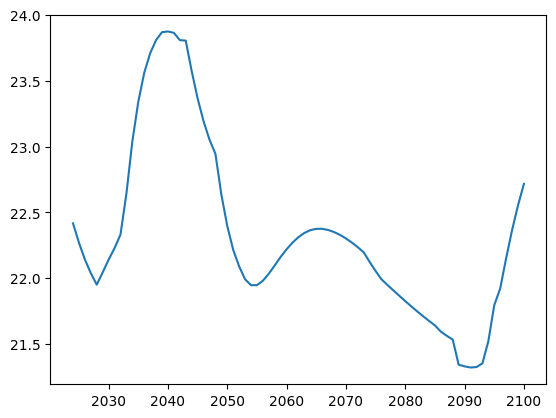

In [19]:
def get_changes(cand_id):
    cand = experimenter.get_candidate_from_id(cand_id)
    cand_outcomes = evaluator.evaluate_candidate(cand)
    cost = cand_outcomes[0]["Adjusted cost of energy per GJ"].iloc[2024-1990:]
    change = cost.diff().shift(-1).dropna()
    plt.plot(range(2024, 2100), change)
    plt.show()

    print(change.tolist())
    print(cost.tolist())

    plt.plot(range(2024, 2101), cost)
    plt.show()

get_changes(examples[0])

In [20]:
for example in examples:
    open_browser(results_dir, example, 0)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [21]:
print(len(actions))

61


In [22]:
from matplotlib.colors import ListedColormap
def get_actions_used(cand_ids):
    x_axis = []
    grid = []
    for cand_id in cand_ids:
        actions_used = np.zeros(len(actions))
        cand = experimenter.get_candidate_from_id(cand_id)
        cand_actions = experimenter.get_candidate_actions(cand, context_input, context_vals)
        for action, val in cand_actions.items():
            row = input_specs[input_specs["varId"] == action].iloc[0]
            if row["defaultValue"] != val:
                if action not in x_axis:
                    x_axis.append(action)
                if row["kind"] == "slider":
                    normalized_val = (val - row["minValue"]) / (row["maxValue"] - row["minValue"])
                else:
                    normalized_val = 1 if val == row["onValue"] else 0
                actions_used[x_axis.index(action)] = normalized_val
        grid.append(actions_used)
    
    # Switch x axis labels to their nicer names
    for i, action in enumerate(x_axis):
        x_axis[i] = input_specs[input_specs["varId"] == action]["varName"].iloc[0]

    grid = np.stack(grid).T[:len(x_axis)]
    grid = np.flip(grid, axis=0)
    plt.figure(figsize=(5, 10))
    plt.yticks(range(len(x_axis)), reversed(x_axis))
    plt.xticks(range(len(cand_ids)), cand_ids, rotation=90)
    plt.title("Number of Actions Used vs. Action Labels")
    plt.imshow(grid, cmap="viridis")

if "Actions taken" in outcomes:
    cand_ids_by_actions = final_pareto.sort_values("Actions taken", ascending=True)["cand_id"].tolist()
    get_actions_used(cand_ids_by_actions)

In [23]:
if "Actions taken" in outcomes:
    from experiments.heuristic import Heuristic
    heuristic = Heuristic(actions)
    actions_order, heuristic_dict = heuristic.find_heuristic()
    heuristic.plot_actions_used(actions_order, heuristic_dict)

In [24]:
heuristic.get_heuristic_urls(actions_order, heuristic_dict)

NameError: name 'heuristic' is not defined

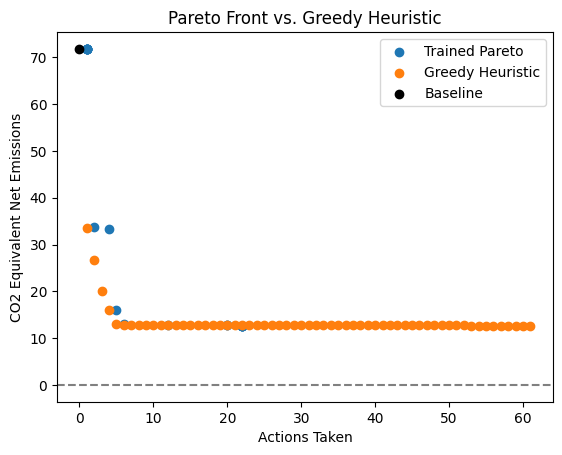

In [ ]:
if "Actions taken" in outcomes:
    temp_actions_dict = {}
    carbons = []
    for i, action in enumerate(actions_order):
        temp_actions_dict[action] = heuristic_dict[action]
        outcome_df = evaluator.enroads_runner.evaluate_actions(temp_actions_dict)
        carbon = outcome_df["CO2 Equivalent Net Emissions"].iloc[-1]
        carbons.append(carbon)

    plt.xlabel("Actions Taken")
    plt.ylabel("CO2 Equivalent Net Emissions")
    plt.scatter(final_pareto["Actions taken"], final_pareto["CO2 Equivalent Net Emissions"], label="Trained Pareto")
    plt.scatter(range(1, len(actions_order)+1), carbons, label="Greedy Heuristic")
    plt.scatter([0], baseline_metrics["CO2 Equivalent Net Emissions"], label="Baseline", color="black")
    plt.axhline(y=0, color="gray", linestyle="--")
    plt.title("Pareto Front vs. Greedy Heuristic")
    plt.legend()
    plt.show()